In [ ]:
data_dir = '2021_10_06_test_data'

plt.rc('image',origin='upper')

In [ ]:
# grab all the fits files
files = glob.glob(os.path.join(data_dir,'*.FIT'))

In [ ]:
for f in files:
    with fits.open(f) as hdu:
        print('{:<80s}'.format(f),hdu[0].header['OBJECT'])

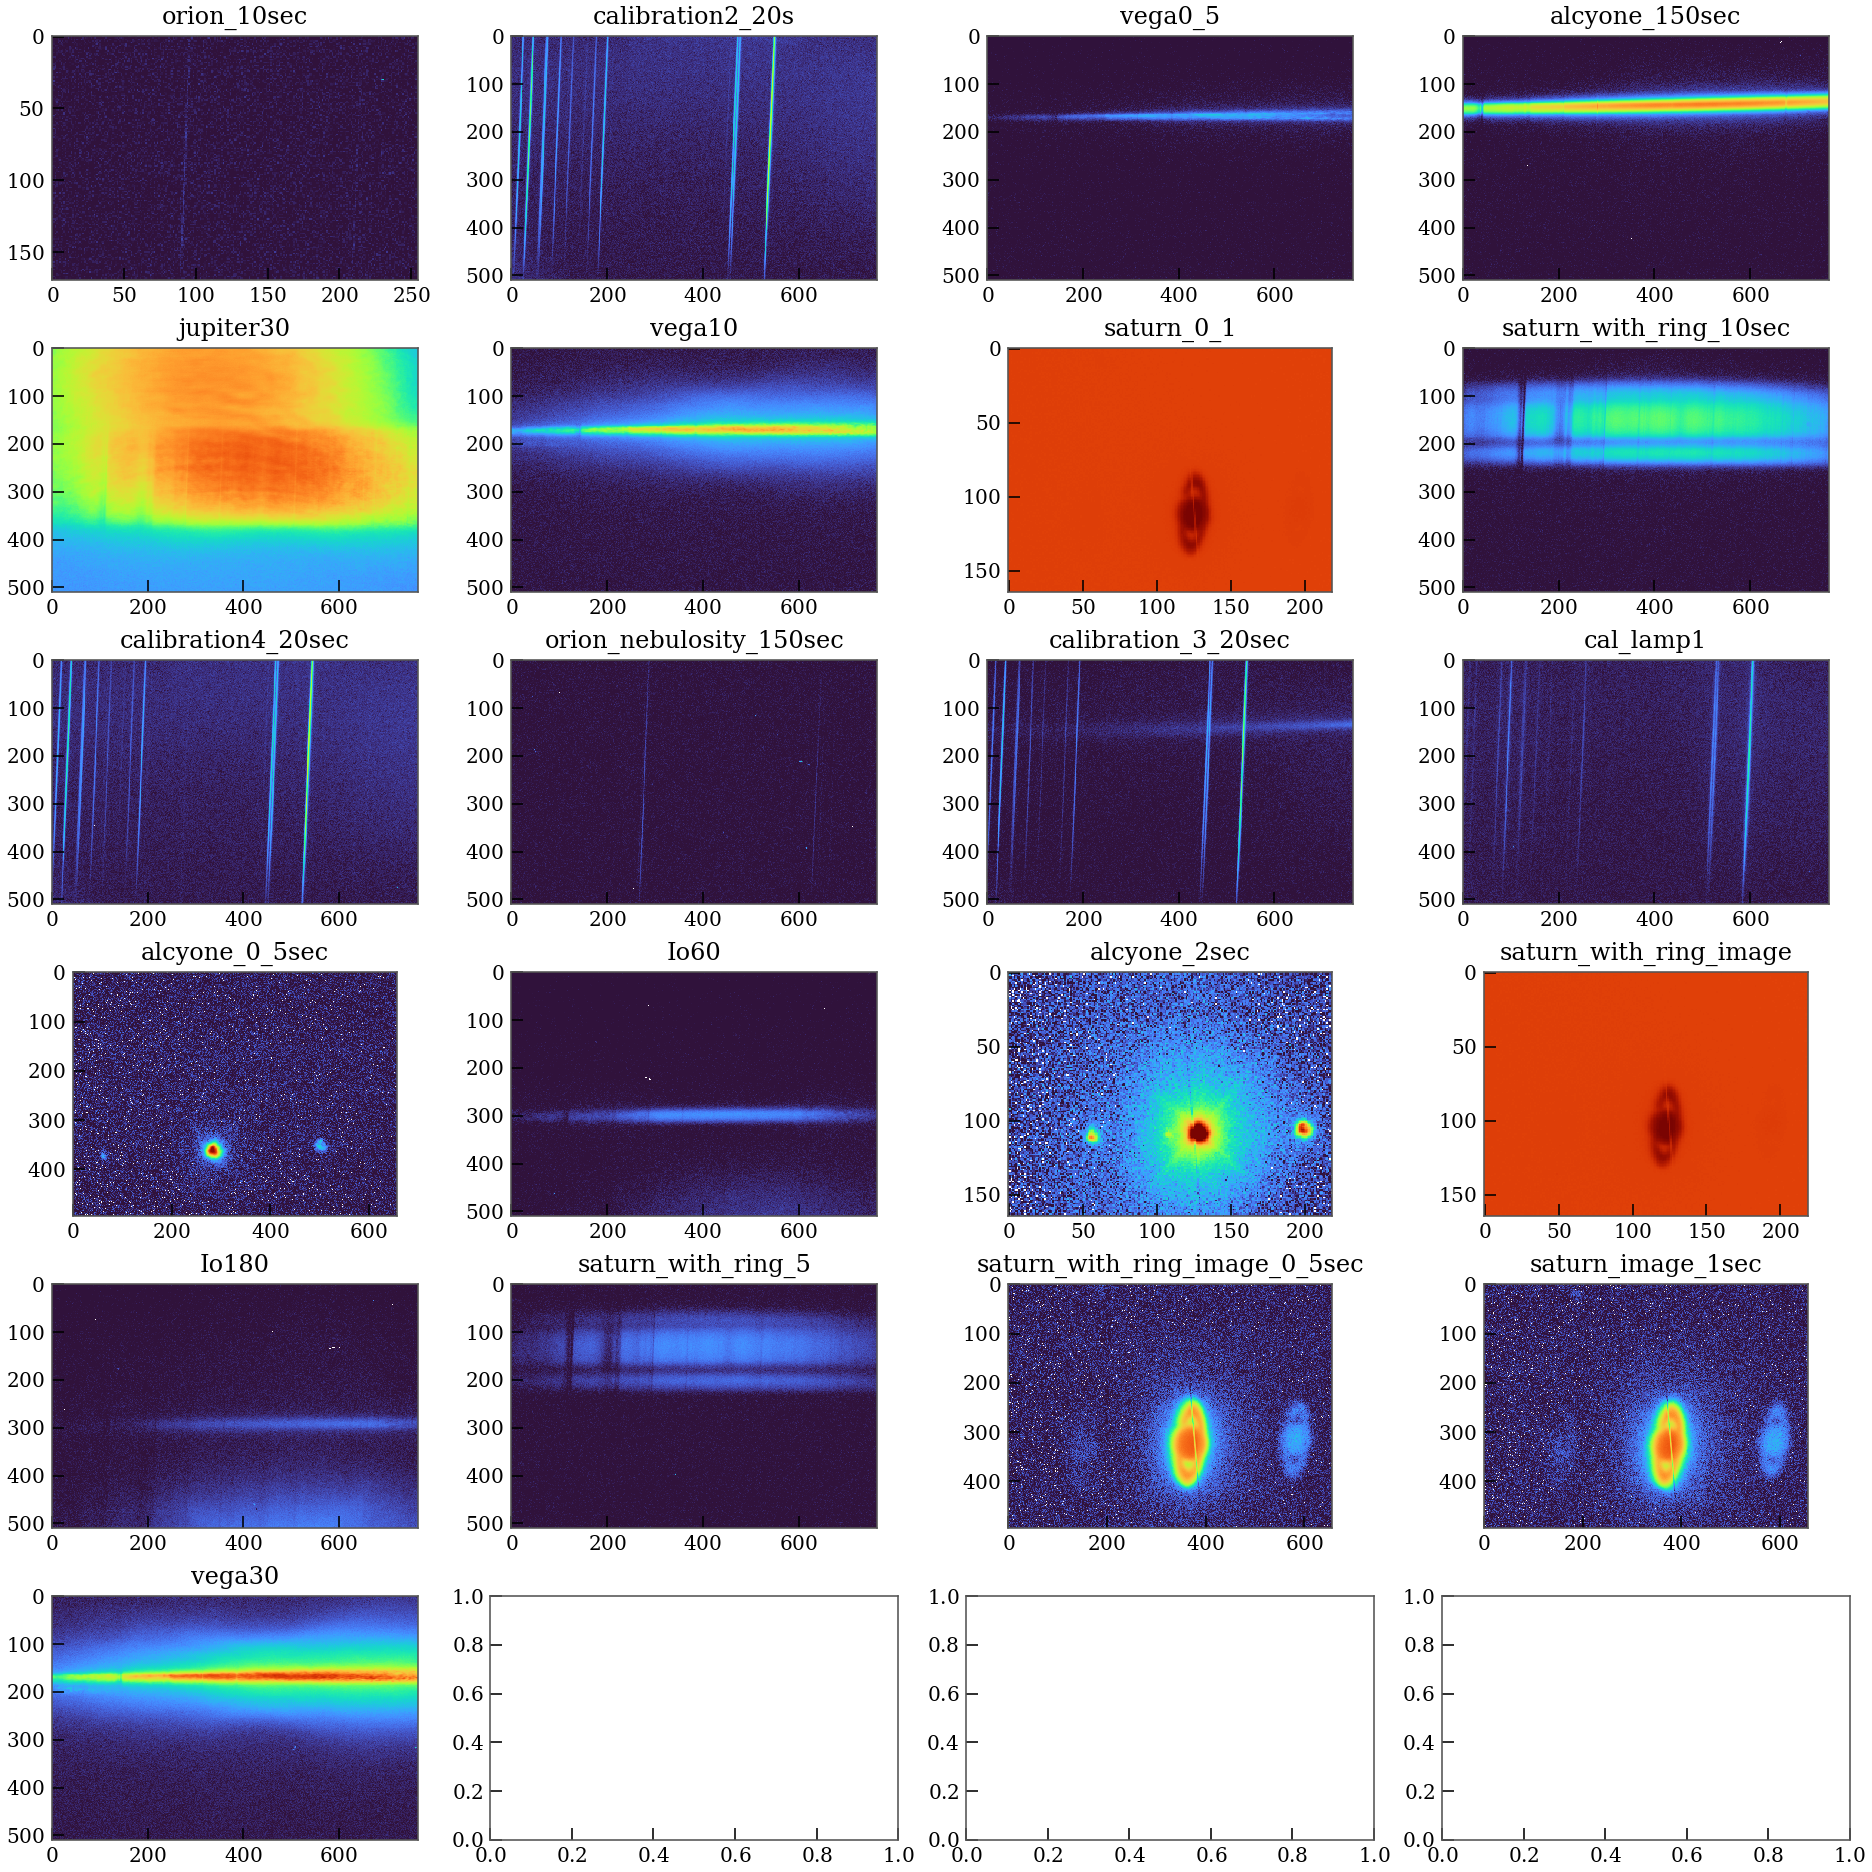

In [804]:
# make a little gallery of object
fig, axs = plt.subplots(int(len(files)/4 + 1),4,figsize=(13,13))
for i,f in enumerate(files):
    with fits.open(f) as hdu:
        axs.flat[i].imshow(hdu[0].data,cmap='turbo',norm=mpl.colors.LogNorm(vmin=100,vmax=65000/2))
        axs.flat[i].set_title(os.path.basename(f)[:-4])

# Reduction pipeline walkthrough

After these section, I show the `reduce` function which does all these steps automatically

In [173]:
# Get all of our helper functions
%run helper_funcs
#%run plot_and_reduce
from plot_and_reduce import *

# load line list and convert to nanometers
hg = np.loadtxt('hgar_blue.txt') / 10
ar = np.loadtxt('argon_red.txt') / 10 

# 1) Read in data

1) Read in your `calibration` and `data` files

In [51]:
# set to true if you want to plot
plot = False

In [52]:
cal_file = data_dir+'/calibration_3_20sec.FIT'
# data = data_dir+'/orion_nebulosity_150sec.FIT'
data_file = data_dir+'/alcyone_150sec.FIT'

# these need to be floats
data = fits.getdata(data_file).astype(float)
cal = fits.getdata(cal_file).astype(float)

if plot:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))

    norm = mpl.colors.LogNorm(vmin=50,vmax=10000)
    ax1.imshow(cal,origin='upper',norm=norm,cmap='magma')
    ax1.set_title('Calibration')
    ax2.imshow(data,origin='upper',norm=norm,cmap='magma')
    ax2.set_title('Data')

# 2) Rectify the images

1) Find the get the brightest line and use it to define the slope
 - Assume the slope is linear

In [53]:
oldcal = cal.copy() # save a copy so we can rerun this cell

In [54]:
# Rectify the data
rect_sol, full_frame_solution = rectify_ccd(oldcal,order=1,plot=False)
cal = shift_row_interp(oldcal,rect_sol,plot=False)
data = shift_row_interp(data,rect_sol,plot=False)

if plot:
    norm = mpl.colors.LogNorm(vmin=50,vmax=10000)
    plt.imshow(oldcal,origin='upper',cmap='magma',norm=norm)
    plt.contour(full_frame_solution,colors=['w']) # overlay the unrectified grid
    plt.title('Calibration frame - Not rectified')


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))


    ax1.imshow(cal,origin='upper',norm=norm,cmap='magma')
    ax1.contour(shift_row_interp(full_frame_solution,rect_sol,plot=False),colors='w')
    ax1.set_title('Calibration - rectified')
    ax2.imshow(data,origin='upper',norm=norm,cmap='magma')
    ax2.set_title('Data - rectified')

    
# White lines show the tile of the spectra lines

# 3) Get spectral range

In [55]:
if plot:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,3))
else:
    ax1, ax2 = None,None

# try the automated way
sl = specextract(data,plot=plot,ax=ax1)

# try the manually by inspecting
# 'Data-rectified' figure
sl = specextract(data,bottom=100,top=200,plot=plot,ax=ax2)


if plot:
    ax2.set_title('manual')
    ax1.set_title('automatic')

# We will use the manually defined range, though typically for a source like this
# with a well defined spectrum, we would use the automated method

Boundaries for spectra 107 179
Boundaries for spectra 100 200


# 4) Wavelength calibration

The hard way

_The one benefit is that you can plot the location of the peaks yourself_

_The reduction pipeline is hardcoded to match the 4 bluest lines_

In [58]:
plot=True

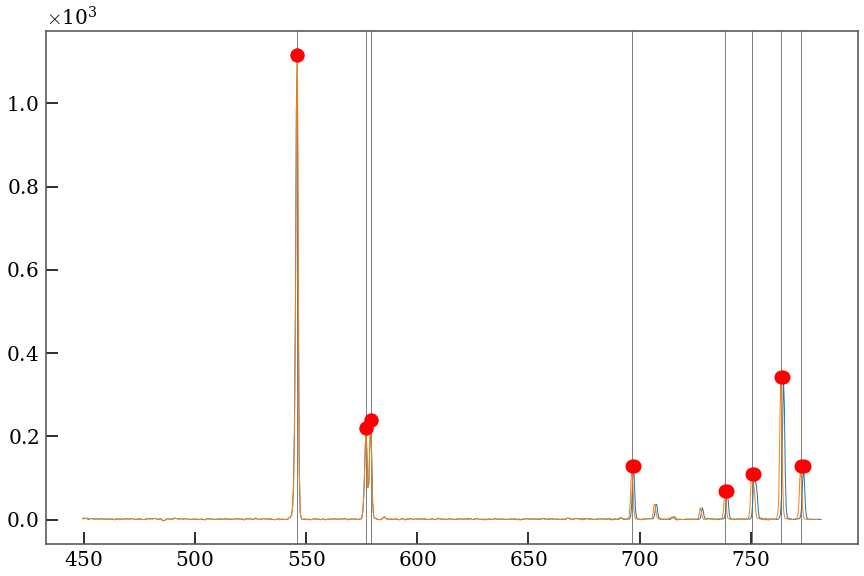

In [330]:
# We can run the functions ourselves
cal_spec = np.nanmean(cal[sl,:],axis=0)
back = findback1d(cal_spec,s=20)
peaks = find_peaks(cal_spec-back,threshold=.05,size=5,)[::-1] # put in wavelength order
p = np.polyfit(peaks[:3],hg[-3:],1)
#p = wavelength_cal(peaks,hg,ar)
λ = np.polyval(p,np.arange(len(cal_spec)))
if plot:
    plt.plot(λ,cal_spec-back,'-',lw=.5)
    plt.plot(np.interp(peaks,x,λ),np.interp(peaks,x,cal_spec-back),'ro')

    
linelist = np.append(hg,ar)
new = np.interp(peaks,np.arange(len(cal_spec)),λ)
c = linelist[np.argmin(np.abs(new - linelist[:,np.newaxis]),axis=0)]
for i in c:
    plt.axvline(i,zorder=0,color='0.5',lw=.5)
    
p2 = np.polyfit(peaks,c,2)
λ2 = np.polyval(p2,np.arange(len(cal_spec)))
if plot:
    plt.plot(λ2,cal_spec-back,'-',lw=.5)
    plt.plot(np.interp(peaks,x,λ2),np.interp(peaks,x,cal_spec-back),'ro')


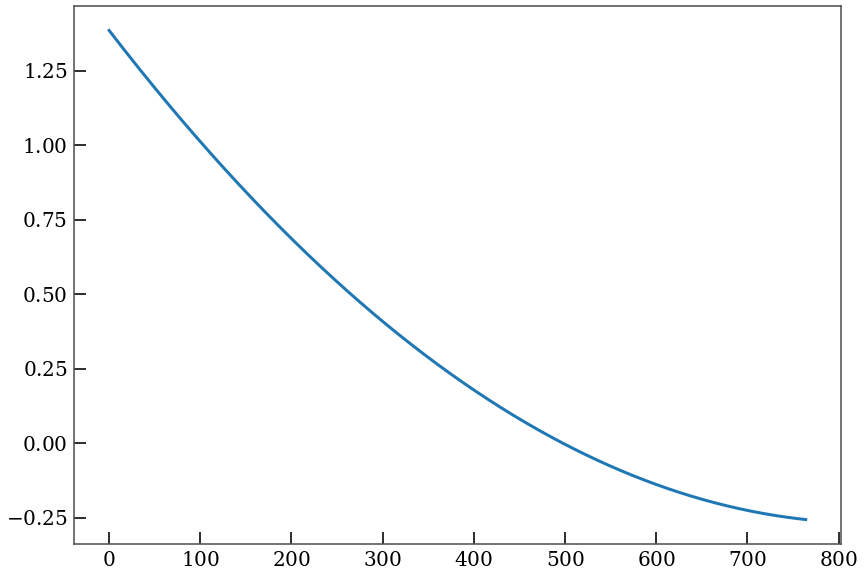

In [331]:
plt.plot(λ-λ2)

In [293]:
# best = []
# std = 100


array([546.075 , 576.961 , 579.067 , 696.5431, 696.5431, 696.5431,
       706.7218, 706.7218, 714.7042, 727.2936, 738.398 , 738.398 ])

In [282]:
hg[hg>540]

array([546.075, 576.961, 579.067])

In [275]:
std,best,scale

(0.5354298469167871,
 array([696.5431, 706.7218, 714.7042, 727.2936, 750.3869, 763.5106,
        772.4207, 794.8176]),
 0.5120278398766959)

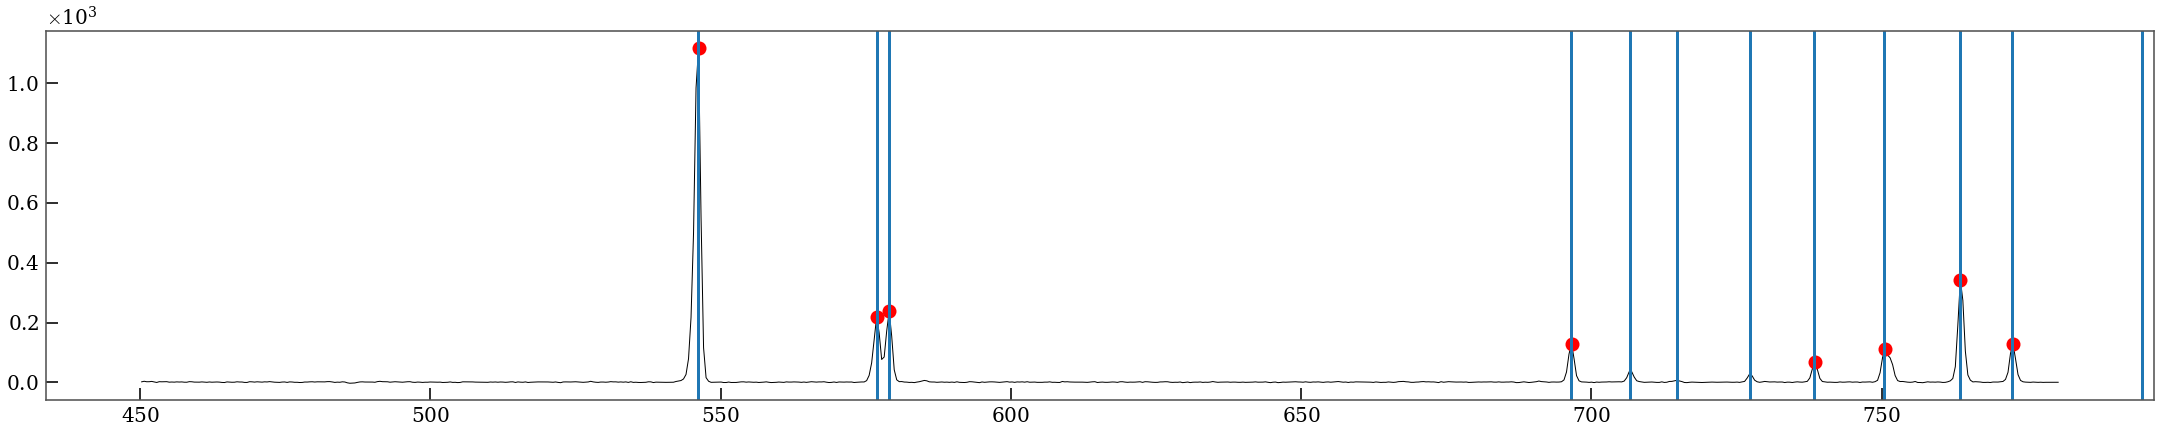

In [277]:
plt.figure(figsize=(15,3))
plt.plot(λ,cal_spec-back,'k',lw=.5)
x = np.arange(len(cal_spec))
plt.plot(np.interp(peaks,x,λ),np.interp(peaks,x,cal_spec-back),'ro')
for i in linelist:
    plt.axvline(i)


In [141]:
c

array([18.        ,  2.78822733])

The easy way

Wavelength solution
-0.43215 x + 780.41


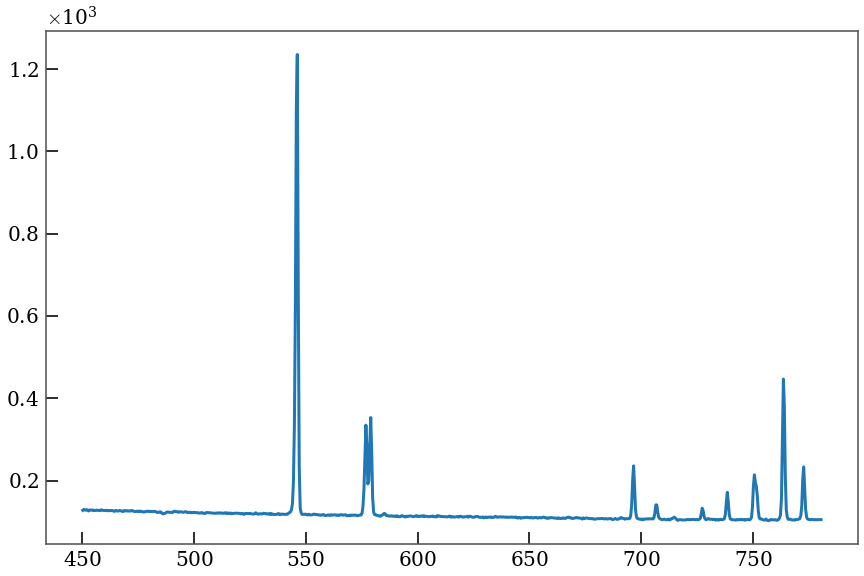

In [40]:
# or we can use the convenience function
p, λ, cal_spec = get_wavelength_solution(cal[sl,:])

plt.plot(λ,cal_spec)

# 5) Plot target spectrum

Text(0.5, 0, 'wavelength [nm]')

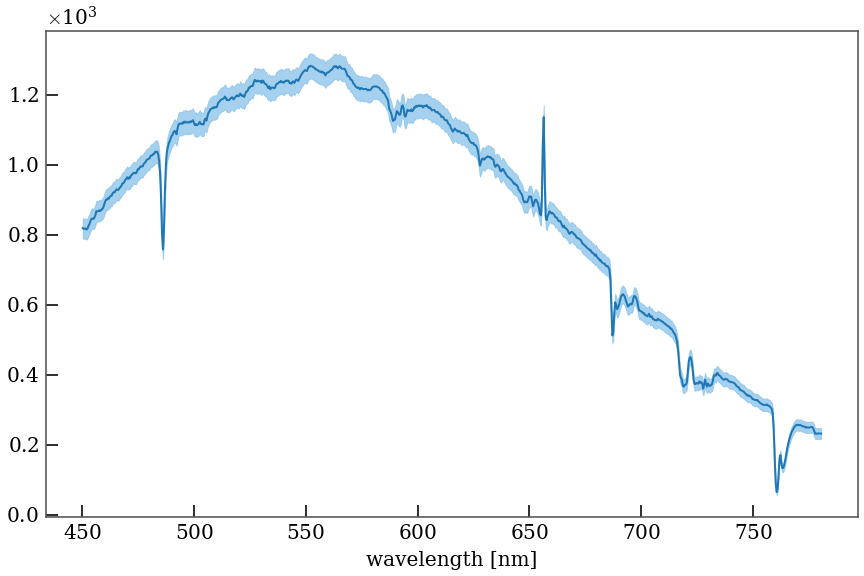

In [43]:
# the 100 accounts for the 100 valued bias/offset
spec = np.mean(data[sl,:] -100., axis = 0)
noise = np.sqrt(spec) # the full reduction uses sigma clipping to include the 

ax = errorbar_fill(λ, spec,noise)
ax.set_xlabel('wavelength [nm]')

# 6) Save the spectrum

In [81]:
out = list(zip(λ,spec,noise))
fname = f"{data_file.replace('.FIT','.tsv')}"

In [82]:
with open(fname,'w') as f:
    f.write('wavelength\tspectrum\terror\n')
    for i in out:
        f.write('{:<9.3f}\t{:>10.3f}\t{:>10.3f}\n'.format(*i))

# Manual reduction

Wavelength solution
-0.43139 x + 807.38
Wavelength solution
-0.43139 x + 807.38
Wavelength solution
-0.43139 x + 807.38
Wavelength solution
-0.43215 x + 807.63
Wavelength solution
-0.43215 x + 807.63


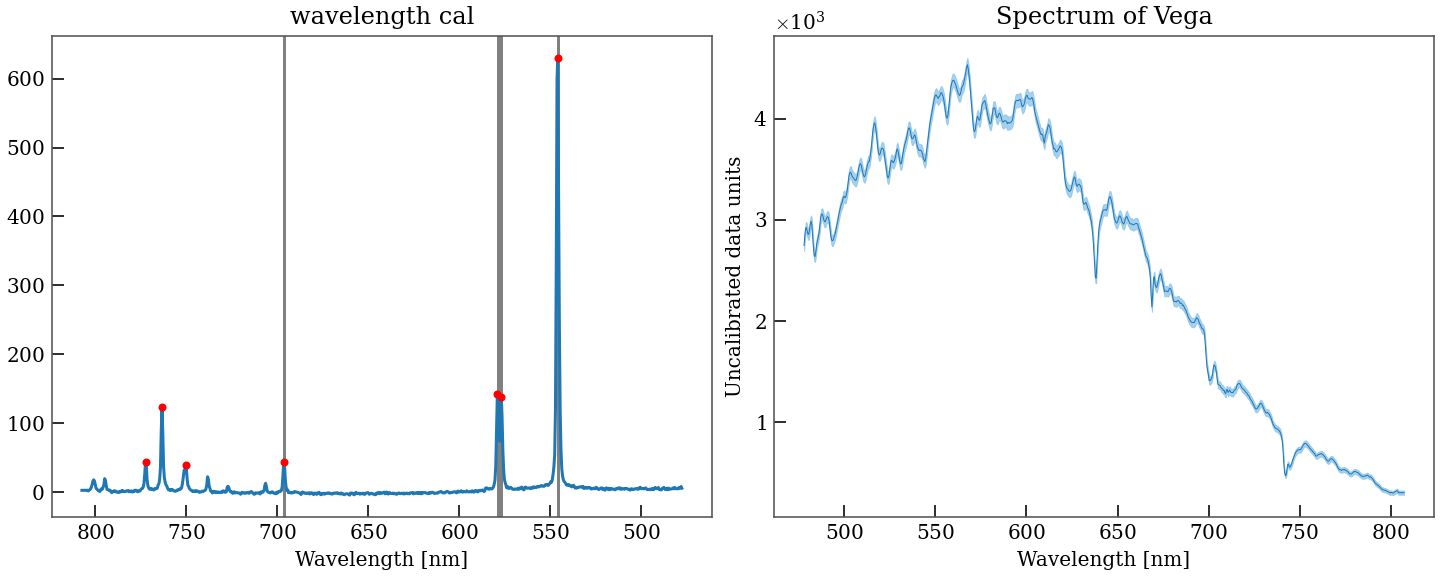

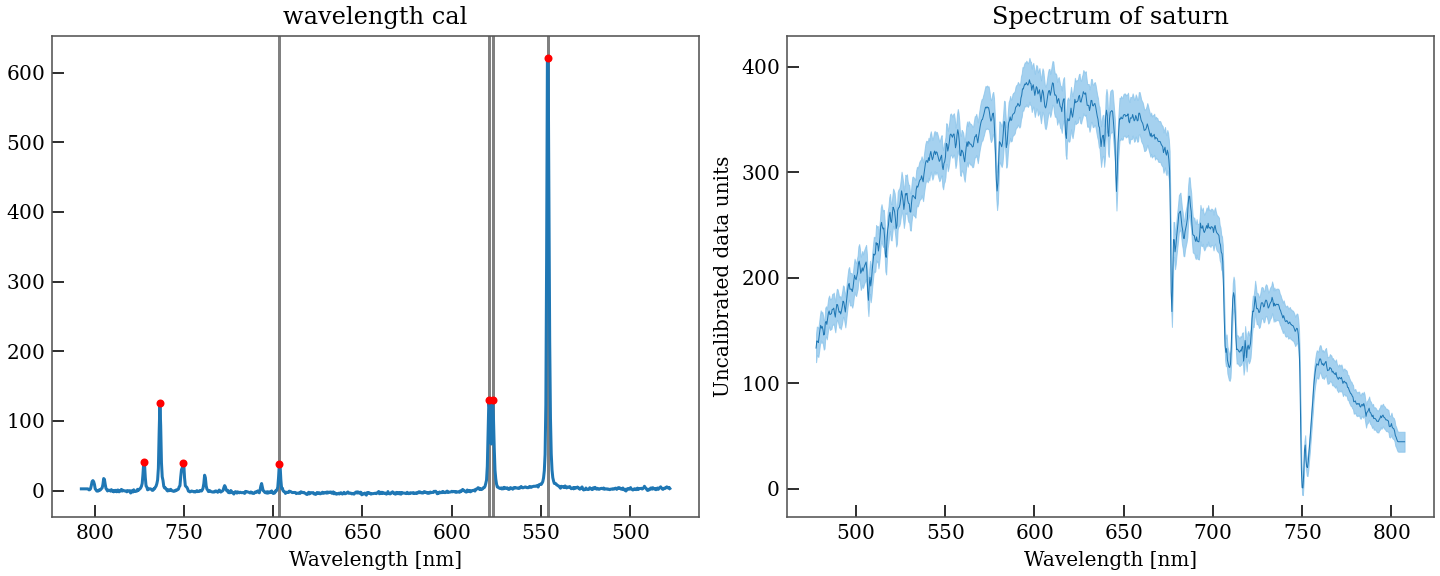

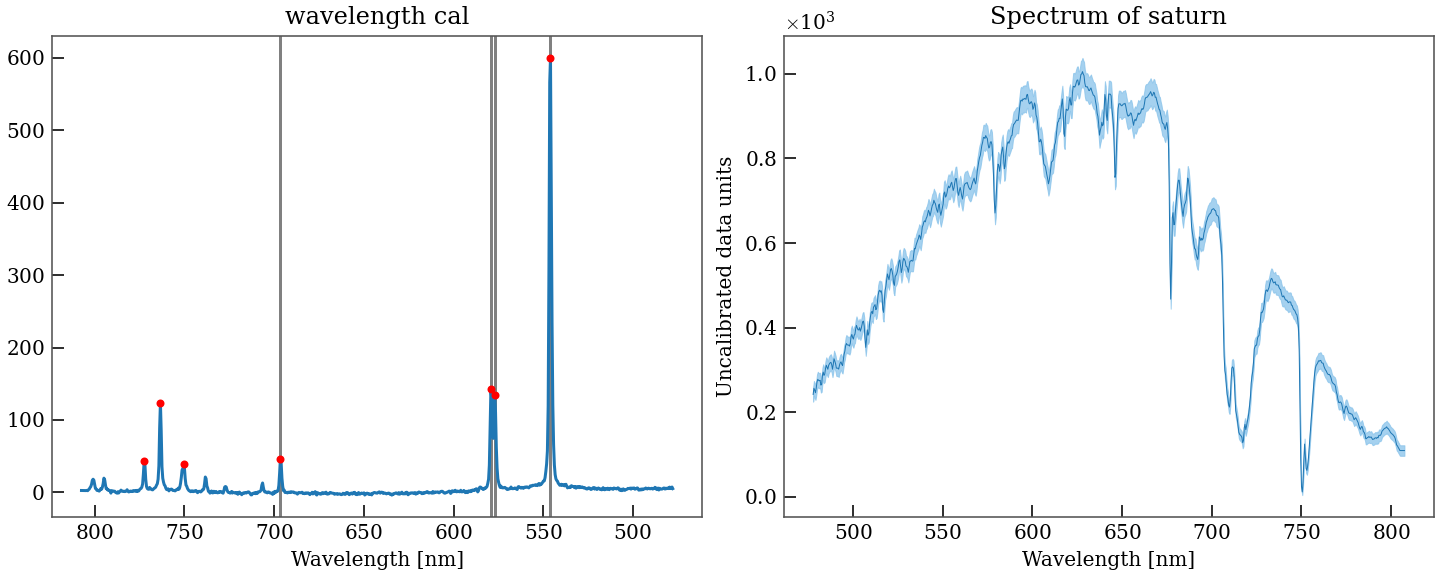

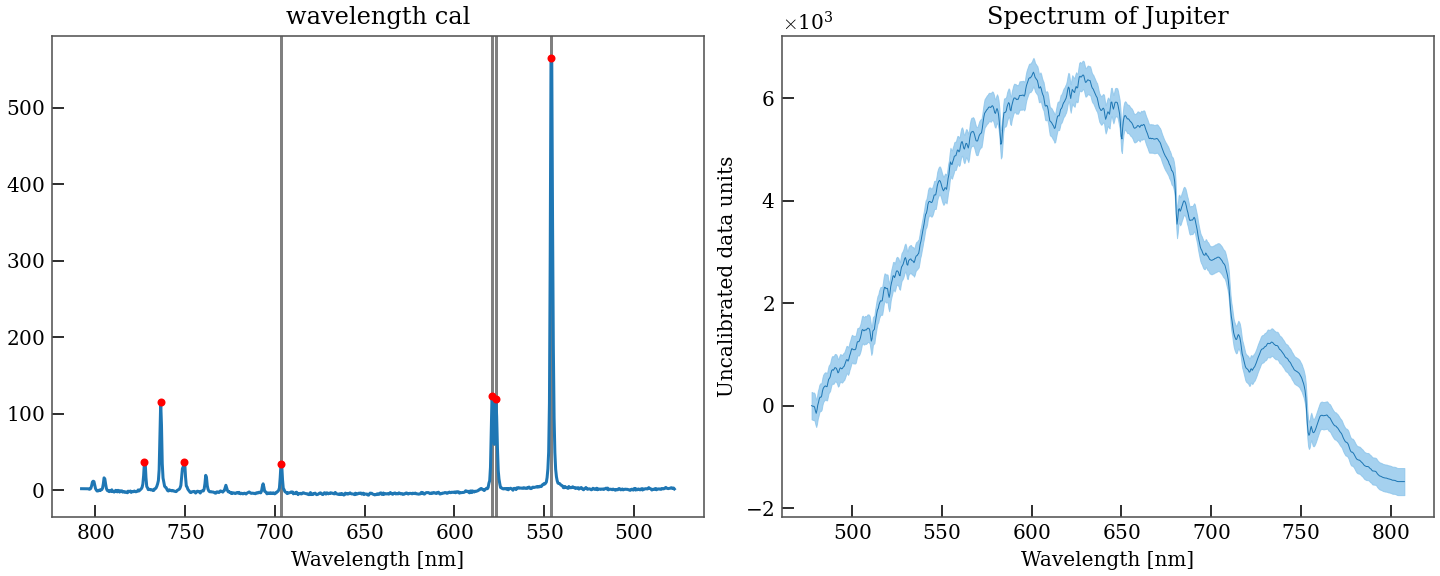

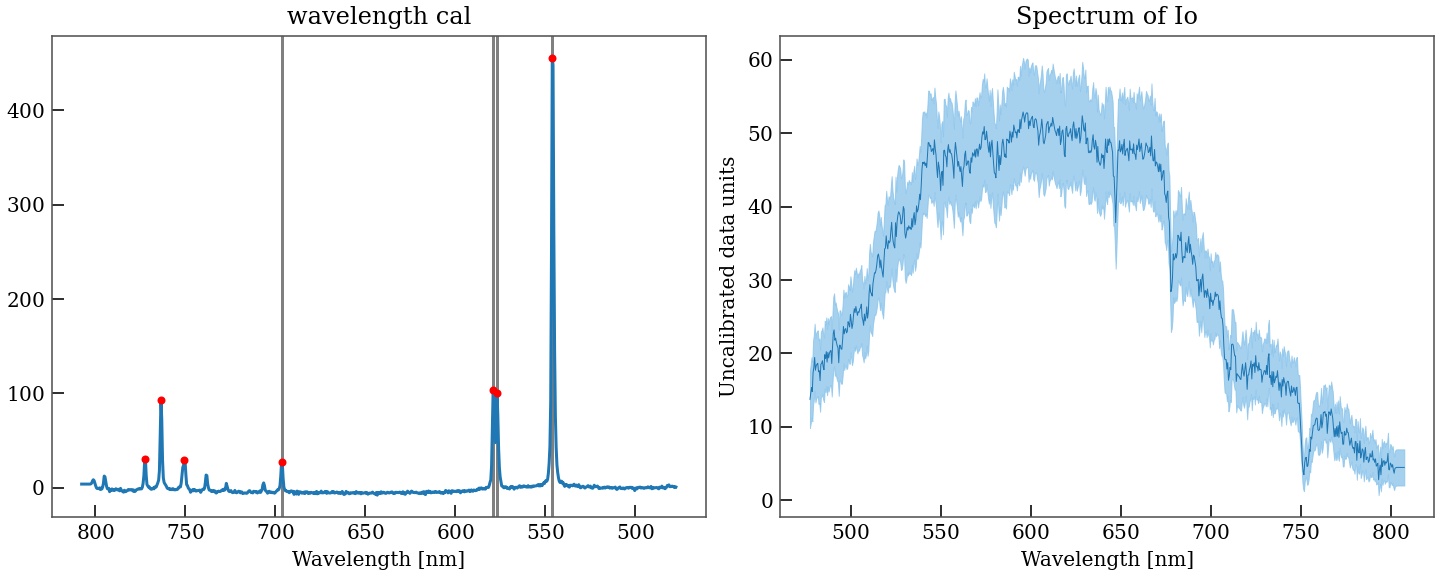

In [44]:
cal = '2021_10_06_test_data/cal_lamp1.FIT'

data = '2021_10_06_test_data/vega30.FIT'
out = reduce(cal,data,rectify=True,plot=False)

data = '2021_10_06_test_data/saturn_with_ring_10sec.FIT'
wavesol_ring,spec_ring,noise_ring = reduce(cal,data,bottom=200,top=250,rectify=True,plot=False)
wavesol_planet,spec_planet,noise_planet = reduce(cal,data,bottom=125,top=175,rectify=True,plot=False)

data = '2021_10_06_test_data/jupiter30.FIT'
wavesol_jup,spec_jup,noise_jup = reduce(cal,data,bottom=200,top=300,rectify=True,plot=False)

data = '2021_10_06_test_data/Io60.FIT'
wavesol_io,spec_io,noise_io = reduce(cal,data,rectify=True,plot=False)

Text(0, 0.5, 'Scaled data units')

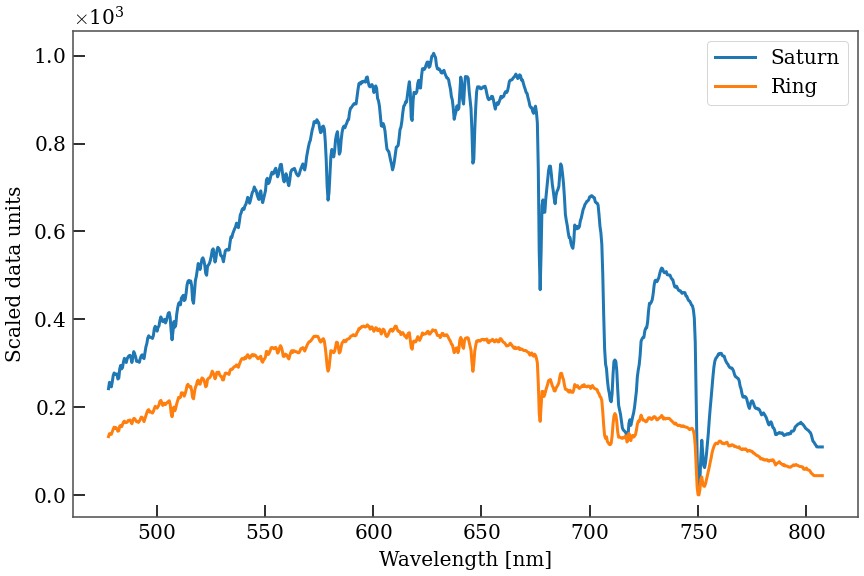

In [28]:
plt.plot(wavesol_planet,(spec_planet),label='Saturn')
plt.plot(wavesol_ring,(spec_ring),label='Ring')
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Scaled data units')

<AxesSubplot:>

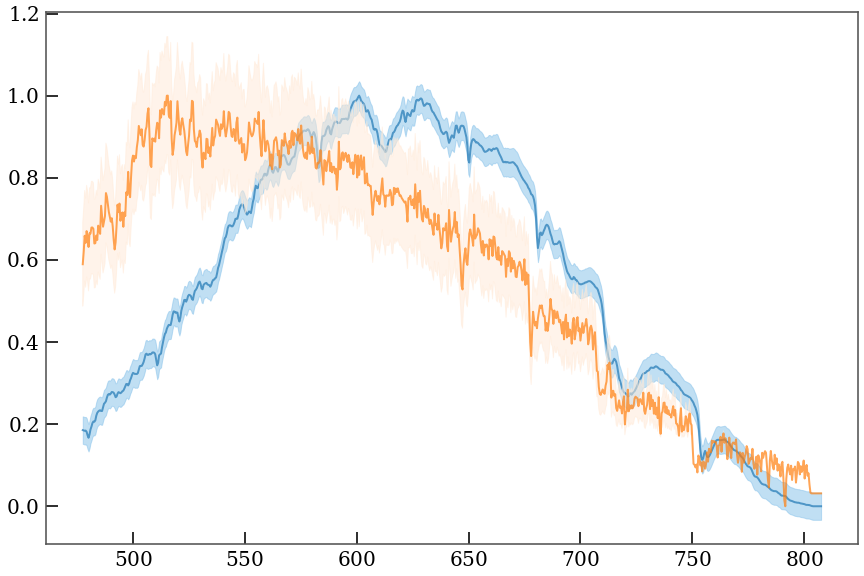

In [31]:
s = np.ptp(spec_jup)
errorbar_fill(wavesol_jup,ju.scale_ptp(spec_jup),noise_jup/s,zorder=0,alpha=0.7)
s = np.ptp(spec_io)
errorbar_fill(wavesol_io,ju.scale_ptp(spec_io),noise_io/s,zorder=1,alpha=0.7)

Wavelength solution
-0.43215 x + 780.41
Wavelength solution
-0.43215 x + 780.41


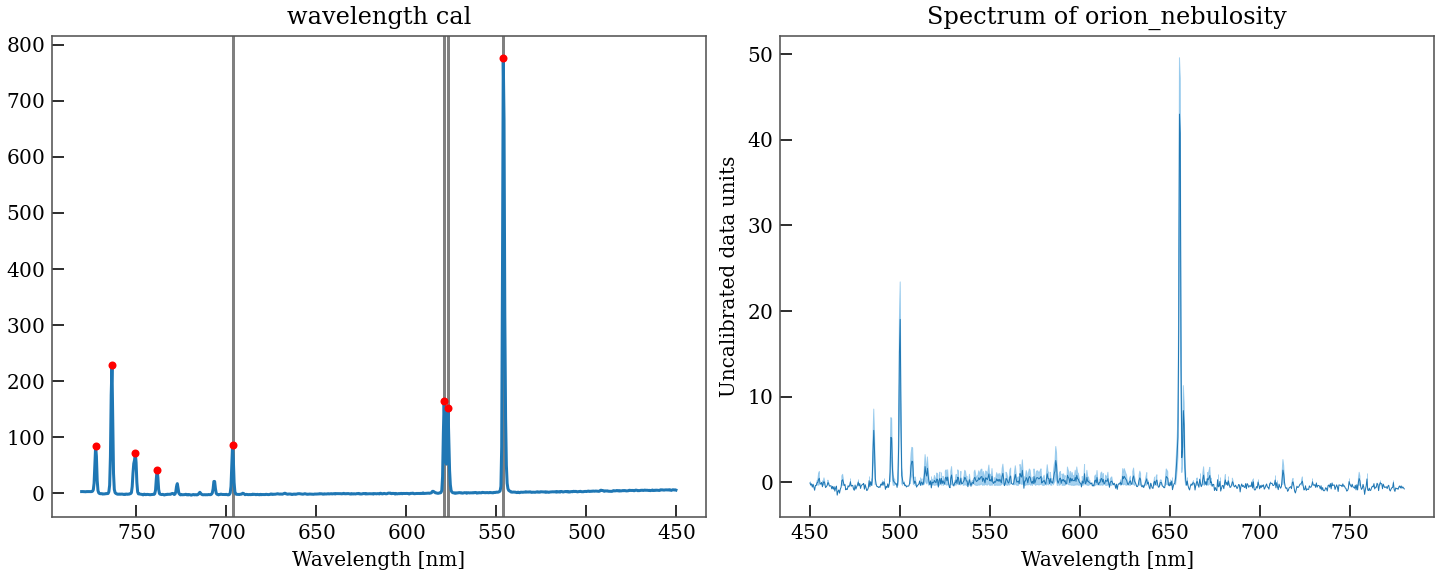

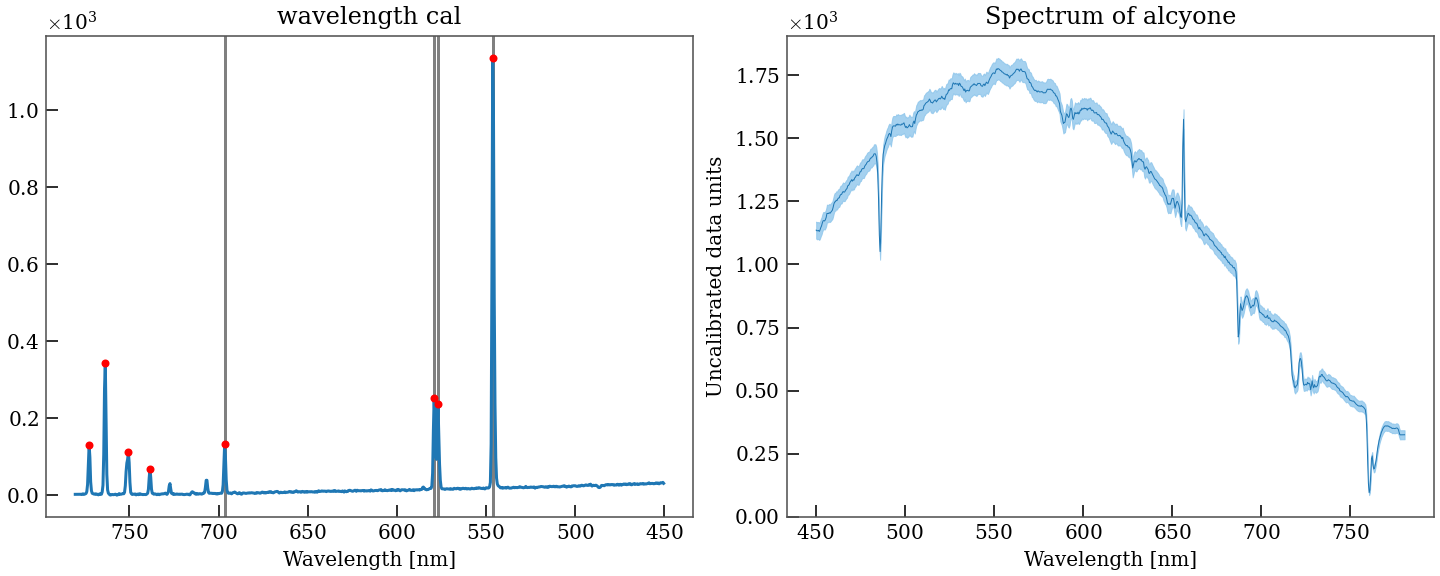

In [902]:
cal = data_dir+'/calibration_3_20sec.FIT'
data = data_dir+'/orion_nebulosity_150sec.FIT'

λ,spec,err = reduce(cal,data,bottom=0,top=510,rectify=True,plot=False,)

data = data_dir+'/alcyone_150sec.FIT'
λ,spec,err = reduce(cal,data,rectify=True,plot=False,)


# Miscellaneous

Below this point are miscellaneous things included plottin the telluric lines and a method for estimating the continuum in the presence of narrow lines

In [766]:
def get_wavelength_solution(cal,threshold=0.05,size=5,plot=False):
    if isinstance(cal,str):
        cal = fits.getdata(cal)
        
    wavesol, _ = rectify_ccd(cal,plot=plot)
    rect = shift_row_interp(cal,wavesol,plot=plot)
    cal_spec = np.nanmean(rect,axis=0)
    peaks = find_peaks(cal_spec,threshold=threshold,size=size,)[0][::-1] # put in wavelength order
    p = wavelength_cal(peaks,hg,ar)
    λ = np.polyval(p,np.arange(rect.shape[1]))
    return p, λ, rect

Wavelength solution
780.41 x + -0.43215


In [768]:
back = findback1d(np.mean(rect,axis=0),s=50,experimental=False)

In [562]:
tellurics = np.loadtxt('atmabs.txt',skiprows=4)

In [745]:
kde=stats.gaussian_kde(tellurics[:,3]/10,weights=1-tellurics[:,2],bw_method=.007) #make a decent telluric spectrum
tell_x = np.linspace(200,1000,10000)

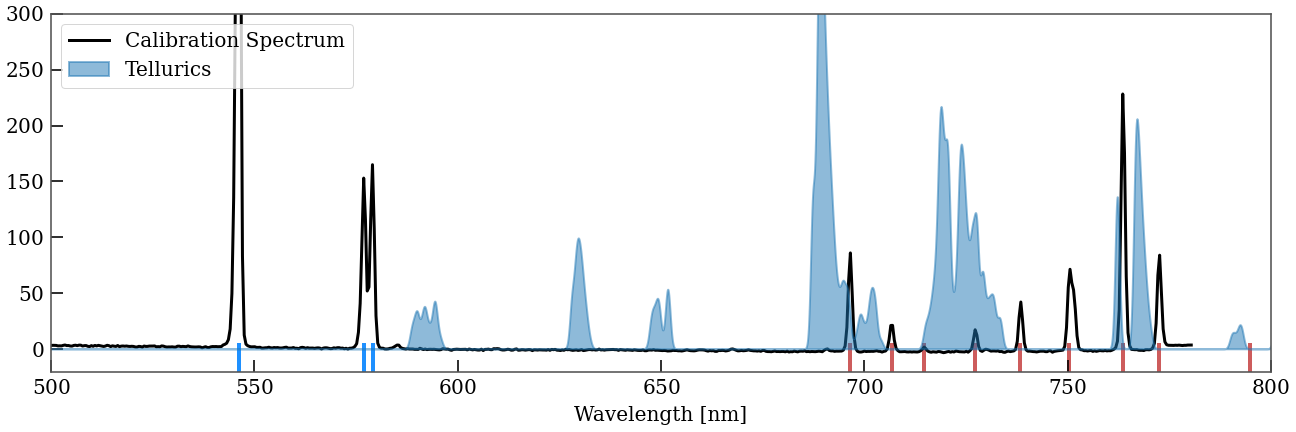

In [764]:
plt.figure(figsize=(9,3),facecolor='w')
plt.plot(λ,np.mean(rect-np.median(rect),axis=0),'k',zorder=1,label='Calibration Spectrum')
plt.fill_between(tell_x,400*ju.scale_ptp(kde(tell_x)),lw=1,zorder=2,color='C0',alpha=0.5,label='Tellurics')
#plt.bar(tellurics[:,3]/10,1-tellurics[:,2],width=(tellurics[:,1]-tellurics[:,0])/10)
# for t in tellurics:
#     plt.axvspan(t[0]/10,t[1]/10,t[2]+.1,1,color='C4',zorder=0)
for c in hg:
    plt.axvline(c,0,.075,color='dodgerblue',lw=2,zorder=0)
for c in ar:
    plt.axvline(c,0,.075,color='indianred',lw=2,zorder=0)
#plt.xlim(650,750)
plt.xlim(500,800)
plt.ylim(-20,300)
plt.xlabel('Wavelength [nm]')
plt.legend(loc='upper left')
plt.savefig('Calibation_spectrum_with_tellurics.png',transparent=False)

In [ ]:
plt.show(

In [ ]:
fig.show(